## Training the Neural Network

This Tutorial was created by C. Baumhoer and is based on work from https://github.com/mmorphew/unet_remote_sensing & https://github.com/karolzak/keras-unet


Again, let's set up the system first.


In [2]:
#import colab package and mount you accounts associated google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/MET-3

Mounted at /content/drive
/content/drive/MyDrive/MET-3


In [3]:
%pip install opencv-python matplotlib scikit-image tensorflow keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


----- Set up the Python environment -----

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from skimage.transform import resize
from skimage.util import random_noise

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import backend as K

We won't use all of these loss metrics at first, but let's go ahead and define them in case we decide to change our loss function later.

In [5]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

----- read in the data ------

In [6]:
data = np.load('./data_train.npy')
labels = np.load('./label_train.npy')
data_test = np.load('./data_test.npy')
labels_test = np.load('./label_test.npy')

We need to tell Tensorflow the size of our input image. This will depend on how we resized the images during preprocessing.

In [7]:
nx = 512
ny = 512

To improve learning, let's standardize globally by subtracting the mean and dividing by the standard deviation.

In [8]:
# Standardization across all samples (band specific)
data_scaled = np.zeros(np.shape(data))
data_normalized = np.zeros((np.shape(data)))
for i in range(np.shape(data)[-1]):
    data_mean = np.mean(data[:,:,:,i])
    data_std = np.std(data[:,:,:,i])
    data_scaled[:,:,:,i] = (data[:,:,:,i]-data_mean)/data_std


In [9]:
# Keep it in the positve range?
data_scaled[:,:,:,i] = np.clip((data_scaled[:,:,:,i]+1.0)/2.0,0,1)


In [10]:
# Standardization across all samples (band specific)
data_test_scaled = np.zeros(np.shape(data_test))
data_test_normalized = np.zeros((np.shape(data_test)))
for i in range(np.shape(data_test)[-1]):
    data_test_mean = np.mean(data_test[:,:,:,i])
    data_test_std = np.std(data_test[:,:,:,i])
    data_test_scaled[:,:,:,i] = (data_test[:,:,:,i]-data_test_mean)/data_test_std

In [11]:
x = data_scaled
y = labels[:,:,:] # exclude clutter
x_test = data_test_scaled
y_test = labels_test[:,:,:]

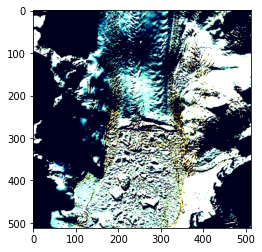

In [12]:
# Plot a random image to see if everything looks alright
plt.imshow(x[15])

Now that we have our data and labels as we want them, we can split our dataset into a portion for training and a portion for validation.

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=1234)

We can further augment our training data by introducing data augmentations where we flip the images in various ways, add noise, etc.

In [14]:
# Data augmentation on just the training data
## Image Augmentation
# Vertical Image
Vx = [np.flip(x, axis=1) for x in x_train]
Vy = [np.flip(x, axis=1) for x in y_train]

# Horizontal Image
Hx = [np.flip(x, axis=2) for x in x_train]
Hy = [np.flip(x, axis=2) for x in y_train]

# Horizontal Vertical Image
HVx = [np.flip(x, axis=2) for x in Vx]
HVy = [np.flip(x, axis=2) for x in Vy]

# Appending the augmented image and mask to the main dataset.
x_train = np.append(x_train, Vx, axis=0)
y_train = np.append(y_train, Vy, axis=0)

x_train = np.append(x_train, Hx, axis=0)
y_train = np.append(y_train, Hy, axis=0)

x_train = np.append(x_train, HVx, axis=0)
y_train = np.append(y_train, HVy, axis=0)


TASK 1: What kind of additional augmentation techniques could we use?

----- Define the neural network -----

In [15]:
# We need some additional layers already pre-defined in Keras
from tensorflow.keras.layers import ( 
        BatchNormalization, Conv2D, Conv2DTranspose,
        MaxPooling2D, UpSampling2D, Input,
        concatenate
    )

In [16]:
#https://github.com/karolzak/keras-unet
def bn_conv_relu(input, filters, bachnorm_momentum, **conv2d_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2D(filters, **conv2d_args)(x)
    return x

def bn_upconv_relu(input, filters, bachnorm_momentum, **conv2d_trans_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2DTranspose(filters, **conv2d_trans_args)(x)
    return x

def satellite_unet(
    input_shape,
    num_classes=1,
    output_activation='sigmoid',
    num_layers=4):

    inputs = Input(input_shape)   
    
    filters = 64
    upconv_filters = 96

    kernel_size = (3,3)
    activation = 'relu'
    strides = (1,1)
    padding = 'same'
    kernel_initializer = 'he_normal'

    conv2d_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':strides,
        'padding':padding,
        'kernel_initializer':kernel_initializer
        }

    conv2d_trans_args = {
        'kernel_size':kernel_size,
        'activation':activation, 
        'strides':(2,2),
        'padding':padding,
        'output_padding':(1,1)
        }

    bachnorm_momentum = 0.01

    pool_size = (2,2)
    pool_strides = (2,2)
    pool_padding = 'valid'

    maxpool2d_args = {
        'pool_size':pool_size,
        'strides':pool_strides,
        'padding':pool_padding,
        }
    
    x = Conv2D(filters, **conv2d_args)(inputs)
    c1 = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)    
    x = bn_conv_relu(c1, filters, bachnorm_momentum, **conv2d_args)
    x = MaxPooling2D(**maxpool2d_args)(x)

    down_layers = []

    for l in range(num_layers):
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        down_layers.append(x)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = MaxPooling2D(**maxpool2d_args)(x)

    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    for conv in reversed(down_layers):        
        x = concatenate([x, conv])  
        x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
        x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
        x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

    x = concatenate([x, c1])
    x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
           
    outputs = Conv2D(num_classes, kernel_size=(1,1), strides=(1,1), activation=output_activation, padding='valid') (x)       
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

Let's create a model object, compile it, and summarize it so we can make sure the layers were built the way we wanted them to be built by Keras. We'll also define our optimizer, Adam, and pick a loss function and tracking metrics.

In [17]:
model = satellite_unet(input_shape=(512, 512, 3), num_classes=2, output_activation='sigmoid', num_layers=3 )
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=["categorical_accuracy", f1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

TASK 2: Do an online search on the terms optimizer (especially Adam), loss function, activation, batch normalization, unet, callback and early stopping. Write down some notes on every term.

----- 

Callbacks instruct Tensorflow how to behave during training. 

In [18]:
#Let's save our model checkpoints relative to epoch and loss
checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'

In [19]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=30, min_lr=0.00001, verbose=1),
    ModelCheckpoint(checkpoint_filepath, monitor='val_categorical_accuracy',
    mode='max',verbose=1, save_best_only=True, save_weights_only=True)
]

----- Before Training, Check the system -------

In [20]:
# Storage
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        3.3G        6.6G        1.2M        2.8G         10G
Swap:            0B          0B          0B


In [23]:
#GPU
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Now let's train our model!

In [ ]:
results = model.fit(x_train, y_train, batch_size= 4, epochs=20, callbacks=callbacks,
                   validation_data=(x_val, y_val))

Epoch 1/20
 2/15 [===>..........................] - ETA: 13:03 - loss: 1.0372 - categorical_accuracy: 0.4814 - f1: 0.5180

TASK 3: Get familiar with the terms epochs and batch size. What impact will we have if you change these parameters?

------ Check Accuracy -------

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(results.history["val_categorical_accuracy"], label="val_categorical_accuracy")
plt.plot(results.history["categorical_accuracy"], label="categorical_accuracy")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

-------- Evaluate the trained weights and predict -------

In [ ]:
# Load best model
#Have a llook at all saved models and take the one with the highest epoch value
model.load_weights("/content/drive/MyDrive/MET-3/weights.07-0.34.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Evaluate on test set
eval = model.evaluate(x_test, y_test)
print('Test loss:', eval[0])
print('Test accuracy:', eval[1])

In [ ]:
# Predict on train, val and test
preds_train = model.predict(x_train[0:10], verbose=1)
preds_val = model.predict(x_val, verbose=1)
preds_test = model.predict(x_test, verbose=1)

In [ ]:
# Threshold prediction probabilities
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

--------- Plot Results --------

In [ ]:
def plot_sample_all(X, y, preds, binary_preds, ix=None, filename='Sample.png'):
    import matplotlib

    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(20, 10))
    r_band = (X[ix,:,:,0]-np.min(X[ix,:,:,0]))/(np.max(X[ix,:,:,0])-np.min(X[ix,:,:,0]))
    g_band = (X[ix,:,:,1]-np.min(X[ix,:,:,1]))/(np.max(X[ix,:,:,1])-np.min(X[ix,:,:,1]))
    b_band = (X[ix,:,:,2]-np.min(X[ix,:,:,2]))/(np.max(X[ix,:,:,2])-np.min(X[ix,:,:,2]))
    RGB = np.stack((r_band, g_band, b_band), axis=-1)

    im0 = ax[0,0].imshow(RGB)
    #if has_mask:
        #ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])

    ax[0,0].set_title('Remote Sensing Image', fontsize=30)
    
        
    im1 = ax[0,1].imshow(X[ix,:,:,0].squeeze(), cmap='gray')

    ax[0,1].set_title('Green', fontsize=30)
    
    im2 = ax[1,0].imshow(X[ix,:,:,2].squeeze(), cmap='gray')

    ax[1,0].set_title('NIR', fontsize=30)
    
    total_mask = np.zeros((512, 512, 3))
    for i in range(512):
        for j in range(512):
            # Ocean
            if(y[ix,i,j,0]==1):
                total_mask[i,j,0]=1
                total_mask[i,j,1]=1
                total_mask[i,j,2]=1
            # Ice
            elif(y[ix,i,j,1]==1):
                total_mask[i,j,0]=0
                total_mask[i,j,1]=0
                total_mask[i,j,2]=1


                
    im3 = ax[1,1].imshow(total_mask)
    ax[1,1].set_title('Image Mask', fontsize=30)
    
    im4 = ax[2,0].imshow(binary_preds[ix,:,:,0].squeeze(), vmin=0, vmax=1)

    ax[2,0].set_title('Ocean (Binary)', fontsize=30)
    
    im5 = ax[2,1].imshow(binary_preds[ix,:,:,1].squeeze(), vmin=0, vmax=1)

    ax[2,1].set_title('Ice (Binary)', fontsize=30)
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.tick_params(axis='both', which='major', labelsize=22)
    fig.tight_layout();
    plt.savefig(filename)

In [ ]:
# Let's see how a prediction on the training data looks like
plot_sample_all(x_train, y_train, preds_train, preds_train_t, ix=9, filename='test.png')

This looks really good. What's about our test data?

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(20, 10))
    band = (X[ix,:,:,0]-np.min(X[ix,:,:,0]))/(np.max(X[ix,:,:,0])-np.min(X[ix,:,:,0]))
    #print(np.shape(RGB))
    im0 = ax[0,0].imshow(band.squeeze(), cmap='gray')
    #if has_mask:
        #ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    fig.colorbar(im0, ax=ax[0,0], fraction=0.046, pad=0.04)
    ax[0,0].set_title('Remote Sensing Image')

    im1 = ax[0,1].imshow(y[ix,:,:,1].squeeze(), vmin=0, vmax=1)
    ax[0,1].set_title('Lable Glacier')
    fig.colorbar(im1, ax=ax[0,1],fraction=0.046, pad=0.04)
    
    im2 = ax[1,0].imshow(preds[ix,:,:,1].squeeze(), vmin=0, vmax=1)
    #if has_mask:
        #ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    fig.colorbar(im2, ax=ax[1,0], fraction=0.046, pad=0.04)
    ax[1,0].set_title('Ice Predicted')
    
    im3 = ax[1,1].imshow(binary_preds[ix,:,:,1].squeeze(), vmin=0, vmax=1)
    #if has_mask:
        #ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    fig.colorbar(im3, ax=ax[1,1], fraction=0.046, pad=0.04)
    ax[1,1].set_title('Ice Predicted (Binary)')
    fig.tight_layout();

In [ ]:
# Check if test data looks all right
plot_sample(x_test, y_test, preds_test, preds_test_t, ix=1)

That looks not as good....Well, we only trained on very little data and would need more training data for sophisticated results!

-------- Accuracy Metrics -------

In [ ]:
x_total = np.concatenate((x_train, x_val, x_test), axis=0)
y_total = np.concatenate((y_train, y_val, y_test), axis=0)
pred_total = np.concatenate((preds_train_t, preds_val_t, preds_test_t), axis=0)

In [ ]:
def print_roc_metrics(y_real, y_predict):

    c_matrix = confusion_matrix(y_real.ravel(), y_predict.ravel())
    f1 = f1_score(y_real.ravel(), y_predict.ravel())
    recall = recall_score(y_real.ravel(), y_predict.ravel())
    precision = precision_score(y_real.ravel(), y_predict.ravel())
    print("Confusion matrix:")
    print(c_matrix)
    print("F1 score: {:.4f}".format(f1))
    print("Recall score: {:.4f}".format(recall))
    print("Precision score: {:.4f}".format(precision))

In [ ]:
print_roc_metrics(y_val, preds_val_t)